In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil
import os.path

import time

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers, sparse
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [3]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [4]:
import utils
from utils import *
from optimizers import *

In [5]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = 'dwt_1005'
assert graphpostfix in graphs
#grid_testcase = nx.grid_graph(dim=(50, 50))
grid_testcase = nx.triangular_lattice_graph(25,25)
#grid_testcase = nx.cycle_graph(100)
grid_testcase_adjacency = nx.adjacency_matrix(grid_testcase).toarray().astype(np.int16)
DEBUG=True
if DEBUG:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=grid_testcase_adjacency, plot_adjacency=False, verbose=True)
else:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=None, plot_adjacency=False, verbose=True)


Name: 
Type: Graph
Number of nodes: 351
Number of edges: 975
Average degree:   5.5556


In [6]:
del G
del A
del D

In [7]:
@jit
def project(X1, C, E_0, c=jnp.array([0,0])):
    C1 = X1.T@X1
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,s,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt
    
    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = X@(-U_E@V_E.T)
    return X.real

@partial(jit, static_argnums=(3,))
def step(i, opt_state, Z, opt_update):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def _D_Z(X, A, P, d, e):
    I = jnp.eye(A.shape[0])
    Ad = A + d*I
    
    Del = jnp.linalg.solve(X.T@jnp.linalg.solve(Ad, X), X.T)@jnp.linalg.solve(Ad, e)
    Z = jnp.linalg.solve(Ad, -X@Del + e)
    
    return Del, Z

@jit
def _sqp(A, P, L, E_0, X):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvals(L)
    idx = w.argsort() 
    w = w[idx]
    E = -E_0 - (A@X + X@L)

    Del_0, Z_0 = _D_Z(X, A, P, w[0], E[:,0])
    Del_1, Z_1 = _D_Z(X, A, P, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del  
@jit
def D_Z(X, A, P, d, e, I):
    Ad = A + d*I

    #sp_solve = lambda _, x: jax.scipy.sparse.linalg.bicgstab(lambda b:Ad@b, x, M=lambda b:M@b, maxiter=100)[0]
    #sp_solve = lambda _, x: jax.scipy.sparse.linalg.gmres(lambda b:Ad@b , x, maxiter=100, solve_method='incremental',M=jnp.linalg.inv(Ad))[0]
    sp_solve = lambda _, x: jnp.linalg.solve(Ad,x)
    ADinvP = sp_solve(Ad, P.T)
    
    #Del = jnp.linalg.solve(X.T@(jnp.linalg.solve(Ad,X)),X.T)@jnp.linalg.solve(Ad,e)
    Del = jnp.linalg.solve(X.T@(sp_solve(Ad,X)),X.T)@sp_solve(Ad,e)
    
    Z = P@(ADinvP@(P@(-X@Del + e)))

    return Del, Z

@jit
def sqp(X, A, P, L, E_0, I):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()  
    w = w[idx].real
    E = -E_0 - (A@X + X@L)
    Del_0, Z_0 = D_Z(X, A, M, P, w[0], E[:,0], I)
    Del_1, Z_1 = D_Z(X, A, M, P, w[1], E[:,1], I)
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del  

def scipy_sqp(X, A, P, L, E_0, I):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()  
    w = w[idx].real
    E = -E_0 - (A@X + X@L)
    Del_0, Z_0 = scipy_D_Z(X, A, P, w[0], E[:,0], I)
    Del_1, Z_1 = scipy_D_Z(X, A, P, w[1], E[:,1], I)
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del  

def bicg_solve(A, B, M):
    if len(B.shape) > 1 and B.shape[1] > 1:
        X, info = zip(*(sp.sparse.linalg.bicgstab(A, b, M=M, tol=1e-6) for b in B.T))
    else:
        X, info = sp.sparse.linalg.bicgstab(A,B, M=M, tol=1e-6)
    return np.transpose(X), info
    

def scipy_D_Z(X, A, P, d, e, I):
    Ad = A + d*I
    Ad = sp.sparse.csc_matrix((A.data, (A.indices[:,0], A.indices[:,1])))
        
    sp_solve = lambda A, b:jnp.array(sp.sparse.linalg.spsolve(A.astype(np.float64),b.astype(np.float64)))
   
    Del = jnp.linalg.solve(X.T@(sp_solve(Ad,X)),X.T)@sp_solve(Ad,e)
    
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    ADE  = (-X@Del + e)
    
    PADE = ADE - v_s@(v_s.T@ADE)
    PADE = PADE - v_s@(v_s.T@PADE)
    ADinvP = sp_solve(Ad, PADE)
    Z = ADinvP - v_s@(v_s.T@ADinvP)
    
    return Del, Z

def newton(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9, initL=True):
    """Perform iterations of PND + backtracking line search."""    
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = np.stack([b_x, b_y], axis=1)
   
    pAp = P@A@P.T

    if initL:
        L = L_init(X_k, C, pAp, E_0)
    
    report = {'x':None, 'lossh':[f(X_k, pAp, pAp, b_x, b_y)[1].item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_sqp(X_k, L, C, pAp, E_0).item()], 'step_sizes':[1], 'L':[L]}
    
    cc = 0
    
    for k in tqdm(range(maxiters)):         
        #Z, Del = sqp(A, P, pAp, L, E_0, X_k)
        Z, Del = _sqp(pAp, P, L, E_0, X_k)
        
        # backtracking line search
        f_xp = jnp.finfo(jnp.float32).max
        stp = 1
        #f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
        f_x = f(X_k, pAp, pAp, b_x, b_y)[0]
        len_p = jnp.linalg.norm(Z)
        X_k_t = X_k
        
        opt_state_t = opt_state
        
        while f_xp >= f_x:
            stp *= beta
            opt_state_t = step(stp, opt_state, -Z, opt_update)
            X_k_t = get_params(opt_state_t)
            f_xp,t = f(X_k_t, pAp, pAp, b_x, b_y)
        
            if stp * len_p < 1e-10:
                break  
        
        #if f_xp.item() > report['lossh'][-1]:
        #    break
        
        L = L + stp*Del
        foc = foc_sqp(X_k, L, C, pAp, E_0)
        
        opt_state = opt_state_t
        X_k = get_params(opt_state_t)
        
        report['sln_path'].append(np.asarray(X_k))
        report['step_sizes'].append(stp)
        report['foc'].append(foc.item())
        #report['lossh'].append(f_xp.item())
        report['lossh'].append(t)
        report['L'].append(np.asarray(L))
        
        if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
            cc += 1
            if cc > 10:
                print('converged')
                break
        if cc > 0:
            cc -= 1
            
    return report

@jit
def subspace(X_k_q, X_k, Z, v, A, E_0, E_00, P, C):
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    
    AXE = A@X_k
    AXE = AXE - v_s@(v_s.T@AXE)+E_00
    
    Q, _ = jnp.linalg.qr(jnp.concatenate([X_k_q, Z, v, AXE],axis=-1), mode='reduced')
    PQ = Q - v_s@(v_s.T@Q)
    B=PQ.T@(A@PQ)
    
    X_k = PQ.T@X_k
    E_0 = PQ.T@E_00 
    X_k = project(X_k, C, E_0)
    
    w_v, v_v = jnp.linalg.eig(B)
    w_v = w_v.real
    v_v = v_v.real
    idx = w_v.argsort()
    v_v = v_v[idx]
    v = Q@v_v[:,0:2]
        
    return Q, PQ, B, X_k, E_0, v

def ssm(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
        maxiters=10, alpha=1e-2, beta=0.9):
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    opt_state, opt_init, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    
    E_00 = jnp.stack([b_x, b_y], axis=1)
       
    cc = 0
    L = jnp.eye(2)
    results = None
    E_0 = E_00

    I = sp.sparse.identity(A.shape[0])
    I = sparse.BCOO.from_scipy_sparse(I)

    v_s = np.ones((A.shape[0],0))/A.shape[0]
    X_k_q = X_k - v_s@((v_s).T@X_k)
    X_k_q = X_k
    #v = jnp.zeros_like(X_k_q)
    v = X_k
    
    M = None 
    print('starting ssm iterations')
    for k in tqdm(range(maxiters)):     
        'Subspace computation'
        Z, Del = scipy_sqp(X_k, A, P, L, E_00, I)

        'initialize wrt subspace'
        qq, Q, B, X_k, E_0, v = subspace(X_k_q, X_k, Z, v, A, E_0, E_00, P, C)
        
        opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: z, 
                                                        E_0, C))    
        
        opt_state = opt_init(X_k)       
        result = newton((opt_state, opt_update, get_params), A, Q.T, L, C, X_k, E_0[:,0], E_0[:,1], 
                        convergence_criterion=convergence_criterion, maxiters=20, alpha=0.0, beta=0.9, initL=True) 
        
        X_k = result['sln_path'][-1]
        L = result['L'][-1]
        
        X_k_q = qq@X_k # PX
        X_k = Q@X_k    # X
        #E_0 = QE_0     # E
        X_k = project(X_k, C, E_00)
        
        if results == None:
            results = result
            results['sln_path'] = [X_k]
            results['lossh'] = [result['lossh'][-1]]            
        
        results['lossh'].extend(result['lossh'])
        results['sln_path'].extend([X_k]*len(result['lossh']))
        results['foc'].extend(result['foc'])
        results['step_sizes'].extend(result['step_sizes'])
    return results

In [8]:
def transform_A(A, X_k, boolean_idx):
    boolean_fixed_idx, boolean_nonfixed_idx = boolean_idx
    X_1x = X_k[boolean_fixed_idx,0]
    X_1y = X_k[boolean_fixed_idx,1]
    X_2  = X_k[boolean_nonfixed_idx]
    A_12 = A[boolean_fixed_idx, :]
    A_12 = A_12[:, boolean_nonfixed_idx]
    
    A = A[boolean_nonfixed_idx, :]
    A = A[:,boolean_nonfixed_idx]
    v_s = np.ones((A.shape[0],1))/np.sqrt(A.shape[0])
    I = np.eye(v_s.shape[0])
    #pap = (I - v_s@v_s.T)@A@(I - v_s@v_s.T)
    pap = A
    #w,v = sp.linalg.eigh(pap)
    w,v = sp.sparse.linalg.eigsh(pap,which='SM')
    print('eigenvalues: ',w)
    X_2[:,0] = v[:,0]
    X_2[:,1] = v[:,1]
    
    b_x = X_1x@A_12
    b_y = X_1y@A_12
    
    return A, X_1x, X_1y, X_2, b_x, b_y

def map_vars(A, X_k, fixed_idx, centercons, decomp=True):
    """Preprocess variables """ 
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = jnp.zeros((k,N))
    for i in range(k):
        fixed_idx=jax.ops.index_add(fixed_idx,jnp.index_exp[i, fixed_indices[i]],1)
    boolean_fixed_idx = fixed_idx.sum(0).astype(bool)
    boolean_nonfixed_idx = (1-fixed_idx.sum(0)).astype(bool)
    
    A, X_1x, X_1y, X_2, b_x, b_y = transform_A(A, X_k, (boolean_fixed_idx, boolean_nonfixed_idx))
    X_k = X_2
    print('computing constraints null space')
    constraints = np.expand_dims(np.ones(X_2.shape[0]),0)
    P = None
    n0_x = jnp.zeros_like(b_x)
    if centercons[1] == centercons[0]:
        n0_y = n0_x
    else:
        n0_y = pinvcons@(np.expand_dims(centercons[1],0))
    return X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx

def cluster(rng, opt_params, X_k, fixed_x, A, mapped_vars, fixed_indices=None, use_fi=False, maxiters=10, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    opt_init, opt_update, get_params = opt_params    
        
    k = fixed_x.shape[0]
    if not use_fi:
        fixed_coordsx = fixed_x[:,0]
        fixed_coordsy = fixed_x[:,1]
    else:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
    
    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    #if D is None:
    #    D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])
    assert jnp.linalg.det(C) > 1e-5
    
    E_0 = jnp.stack([b_x, b_y], axis=1)
    n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = X_k
    print('initial projection')
    X_k_n = project(X_k_n, C, E_0, centercons)

    L = jnp.eye(2)

    opt_state = opt_init(X_k_n)
    print('ssm...')
    result = ssm((opt_state, opt_init, opt_update, get_params), A, P, L, C, X_k_n, b_x, b_y, 
                    convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9) 

    X_k = result['sln_path'][np.argmin(result['lossh'])]

    X_k_n = np.zeros((N,2))
    if not use_fi:
        nonfixed_idx = np.ones(N, dtype=bool)
        nonfixed_idx[fixed_indices] = 0
        X_k_n[fixed_indices,0] = fixed_coordsx
        X_k_n[nonfixed_idx,0] = np.array(X_k[:,0]) + n0_x.T
        X_k_n[fixed_indices,1] = fixed_coordsy
        X_k_n[nonfixed_idx,1] = np.array(X_k[:,1]) + n0_y.T
    else:
        X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
        X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
    
    #result = {}
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(bool)
    result['mask'] = mask
    result['centroid'] = centercons
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)
    
    return result

In [9]:
##### USER PARAMETERS #####
method = "ssm" # pnd, ssm, or pgd


seed = 0 # random seed
eps = 1e-8 # global epsilon variable
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))

if os.path.isfile(graphdir+graphpostfix+'_evals.npy') and \
   os.path.isfile(graphdir+graphpostfix+'_evecs.npy'):
    w = np.load(graphdir+graphpostfix+'_evals.npy')
    v = np.load(graphdir+graphpostfix+'_evecs.npy')    
else:
    w,v = sp.sparse.linalg.eigsh(L, k=min(n,5), which='SM')
    np.save(graphdir+graphpostfix+'_evals.npy',w)
    np.save(graphdir+graphpostfix+'_evecs.npy',v)
if DEBUG:
    w,v = sp.sparse.linalg.eigsh(L, k=min(n,5), which='SM')
X_k = v[:,1:3].real

if DEBUG:
    fixed_indices = np.array([0])
else:
    fixed_indices = np.array([0,1,2,3,4,5,6,7,8,9,10])


X_k[fixed_indices] = X_k_r[fixed_indices]

In [10]:
del w
del v
#del X_k_r
v = jnp.ones(n)

print('initial transformation of variables')

X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))

print('done mapping variables')
A = sparse.BCOO.from_scipy_sparse(A)
mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx)

if method == "pgd":
    pgd_lr = 5e-2
    opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C), b1=0.9, b2=0.999, eps=1e-08)
elif method == "pnd":
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C))
elif method == 'ssm':
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.zeros((8,2)), C))       
else:
    print('method not supported')
    assert False

initial transformation of variables
eigenvalues:  [0.00216122 0.03300745 0.0837413  0.10923181 0.1272525  0.1984993 ]
computing constraints null space
done mapping variables


In [11]:
print('clustering...')

result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, X_k_r[fixed_indices], L, mapped_vars, fixed_indices=fixed_indices, use_fi=False, c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=10, convergence_criterion=1e-3, method=method)
results = [result]
X_k_n=result['x']

clustering...
initial projection
ssm...
starting ssm iterations


  0%|          | 0/10 [00:00<?, ?it/s]

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


  0%|          | 0/20 [00:00<?, ?it/s]

/home/orange3xchicken/.local/lib/python3.7/site-packages/jax/_src/lax/lax.py:451: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

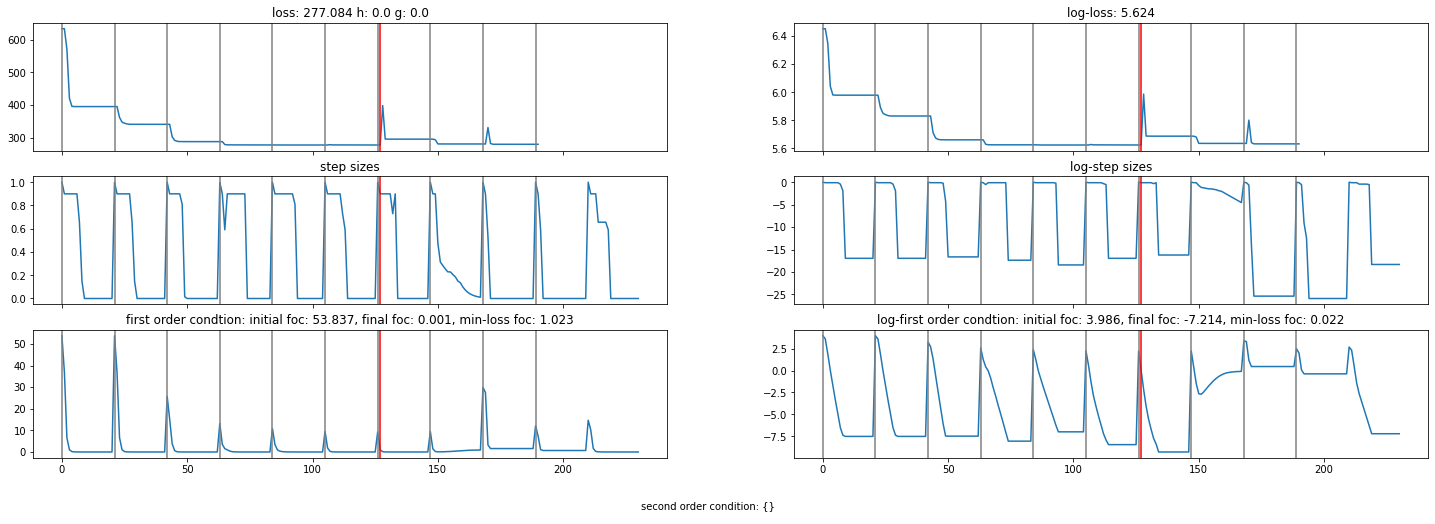

In [12]:
resgraph = utils.plot_results(result)

In [13]:
voxel_id, voxel_bound = voxel_cluster(X_k, np.array([5, 5]))

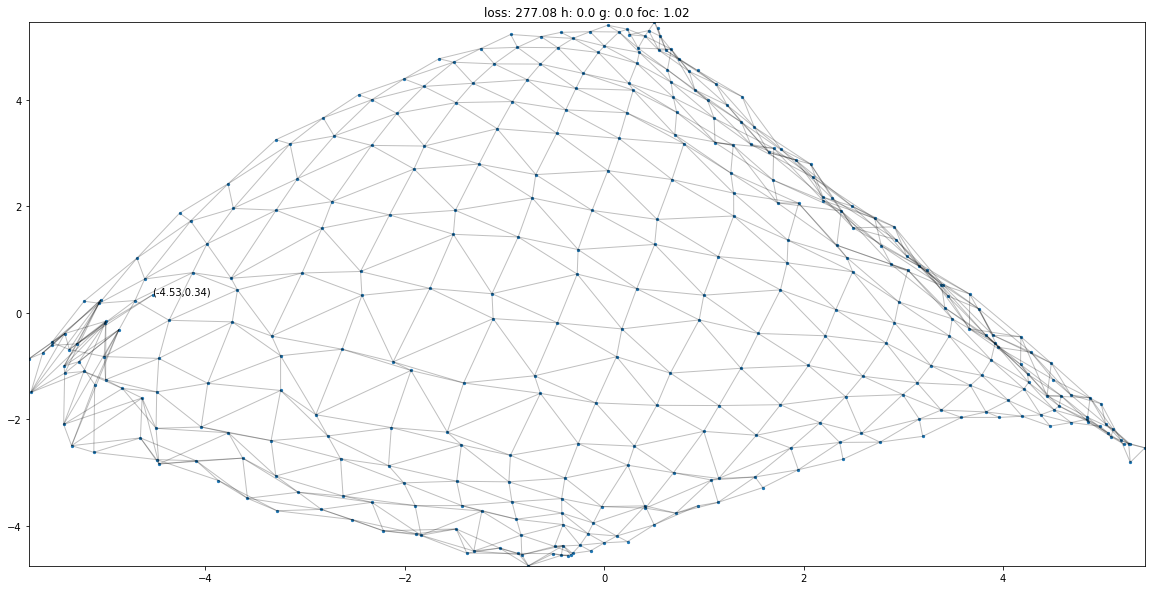

In [14]:
result['h'] = 0.0
result['g'] = 0.0
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(np.min(result['lossh']),2)), 
                                                                            np.round(result['h'],2), np.round(result['g'],2), 
                                                                           str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=None)

In [15]:
#utils.plot_animation(results, graph, fixed_coordinates=X_k_r[fixed_indices])

### 